In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import sys
import pandas as pd
import random
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
import numpy as np
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from tensorflow.keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.models import Model

In [11]:
x = np.load('/content/drive/MyDrive/Datasets/fold3/images.npy')
y = np.load('/content/drive/MyDrive/Datasets/fold3/types.npy')


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 1)


In [13]:
print(x_train.shape, y_train.shape)

(2177, 256, 256, 3) (2177,)


In [14]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [15]:
#encoding y_train

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y_train = onehot_encoded

[ 3  1 17 ...  0  3  6]


In [16]:
#encoding y_test

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_test)
#print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

y_test = onehot_encoded

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train, test_size=.27, random_state=1)
x_train1, x_train3, y_train1, y_train3 = train_test_split(x_train1, y_train1, test_size=.50, random_state=1)


In [18]:
x_test, x_test2, y_test, y_test2 = train_test_split(x_test, y_test, test_size=0.5, random_state= 1)

In [19]:
print((x_train1.shape, y_train1.shape))
print((x_train2.shape, y_train2.shape))
print((x_train3.shape, y_train3.shape))
print((x_test.shape, y_test.shape))
#print((x_test1.shape, y_test1.shape))
print((x_test2.shape, y_test2.shape))

((794, 256, 256, 3), (794, 19))
((588, 256, 256, 3), (588, 19))
((795, 256, 256, 3), (795, 19))
((272, 256, 256, 3), (272, 19))
((273, 256, 256, 3), (273, 19))


In [20]:
# y_test = to_categorical(y_test)
# y_train1 = to_categorical(y_train1)
# y_train2 = to_categorical(y_train2)

**REsNet50 using for folder 3**

In [21]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )

In [22]:
train_generator.fit(x_train)

In [23]:
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)

In [24]:
test_generator.fit(x_test)

In [25]:
# #Learning Rate Annealer
# from keras.callbacks import ReduceLROnPlateau
# lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01,  patience=3, min_lr=1e-5)

In [26]:
#Initializing ResNet50
from tensorflow.keras.applications import ResNet50
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

94781440/94765736 [==============================] - 0s 0us/step


In [27]:
#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))

#Summary of ResNet50 Model
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [28]:
from tensorflow.keras.optimizers import SGD


In [29]:
model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train ,y_train, epochs=20, validation_data =(x_test, y_test), verbose=1)

Epoch 1/20
69/69 [==============================] - 211s 3s/step - loss: 2.1543 - accuracy: 0.4175 - val_loss: 3.5703 - val_accuracy: 0.2022
Epoch 2/20
69/69 [==============================] - 204s 3s/step - loss: 1.7637 - accuracy: 0.4970 - val_loss: 9.1392 - val_accuracy: 0.2022
Epoch 3/20
69/69 [==============================] - 205s 3s/step - loss: 1.7616 - accuracy: 0.5016 - val_loss: 9.2006 - val_accuracy: 0.2831
Epoch 4/20
69/69 [==============================] - 205s 3s/step - loss: 1.5967 - accuracy: 0.5457 - val_loss: 11.6389 - val_accuracy: 0.0478
Epoch 5/20
69/69 [==============================] - 208s 3s/step - loss: 1.7888 - accuracy: 0.4956 - val_loss: 52.6692 - val_accuracy: 0.0515
Epoch 6/20
69/69 [==============================] - 318s 5s/step - loss: 1.7239 - accuracy: 0.5241 - val_loss: 5.6874 - val_accuracy: 0.3566
Epoch 7/20
69/69 [==============================] - 338s 5s/step - loss: 1.4437 - accuracy: 0.5737 - val_loss: 12.5158 - val_accuracy: 0.2022
Epoch 8/20

In [31]:
model_resnet.save('resNet50 epoch 20 fold2 x_train.h5')

**ResNet50 Model for ensembling, fold 3**

In [32]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
train_generator.fit(x_train1)
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
test_generator.fit(x_test2)


#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))

#Summary of ResNet50 Model
model_resnet.summary()

model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train1 ,y_train1, epochs=20, validation_data =(x_test2, y_test2), verbose=1)
model_resnet.save('resNet50-epoch25-fold3.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_5 (Dense)             (None, 1024)              134218752 
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)              

**VGG19 using for folder3**

In [33]:
# from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, batch_size = 128, epochs = 25, verbose = 1, validation_data = (x_test, y_test))

	# evaluate model
	_, acc = model.evaluate(x_train, y_train, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# save model
	model.save('vgg19 fold2 20 epoch x_train.h5')


run_test_harness()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/25
18/18 [==============================] - 143s 8s/step - loss: 7.0475 - accuracy: 0.2049 - val_loss: 2.7695 - val_accuracy: 0.2463
Epoch 2/25
18/18 [==============================] - 135s 7s/step - loss: 2.4122 - accuracy: 0.3505 - val_loss: 2.3386 - val_accuracy: 0.3346
Epoch 3/25
18/18 [==============================] - 134s 7s/step - loss: 1.9480 - accuracy: 0.4217 - val_loss: 2.2542 - val_accuracy: 0.3750
Epoch 4/25
18/18 [==============================] - 135s 8s/step - loss: 1.8521 - accuracy: 0.4557 - val_loss: 2.1865 - val_accuracy: 0.4154
Epoch 5/25
18/18 [==============================] - 132s 7s/step - loss: 1.4682 - accuracy: 0.5462 - val_loss: 2.1267 - val_accuracy: 0.4191
Epoch 6/25
18/18 [==============================] - 128s 7s/step - loss: 1.2916 - accuracy: 0.5999 - val_loss: 2.2170 - val_accuracy: 0.4301
Epoch 7/25
18/18 [==============================] - 130s 7s/step - loss: 1.3980 - accuracy: 0.6017 - val_loss: 2.1413 - val_accuracy: 0.4154
Epoch 8/25
18

In [34]:
# from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, batch_size = 128, epochs = 40, verbose = 1, validation_data = (x_test, y_test))

	# evaluate model
	_, acc = model.evaluate(x_train, y_train, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# save model
	model.save('vgg19 fold2 40 epoch x_train.h5')


run_test_harness()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
18/18 [==============================] - 142s 8s/step - loss: 8.4639 - accuracy: 0.2490 - val_loss: 4.2602 - val_accuracy: 0.3713
Epoch 2/40
18/18 [==============================] - 135s 8s/step - loss: 4.0660 - accuracy: 0.3381 - val_loss: 2.2423 - val_accuracy: 0.3824
Epoch 3/40
18/18 [==============================] - 136s 8s/step - loss: 1.8924 - accuracy: 0.4593 - val_loss: 2.0859 - val_accuracy: 0.4412
Epoch 4/40
18/18 [==============================] - 136s 8s/step - loss: 1.7995 - accuracy: 0.4708 - val_loss: 2.1106 - val_accuracy: 0.4338
Epoch 5/40
18/18 [==============================] - 133s 7s/step - loss: 1.5326 - accuracy: 0.5324 - val_loss: 2.0069 - val_accuracy: 0.4449
Epoch 6/40
18/18 [==============================] - 136s 8s/step - loss: 1.3680 - accuracy: 0.5765 - val_loss: 2.0602 - val_accuracy: 0.4706
Epoch 7/40
18/18 [==============================] - 135s 8s/step - loss: 1.2987 - accuracy: 0.5916 - val_loss: 2.0532 - val_accuracy: 0.4559
Epoch 8/40
18

**VGG19 for ensembling fold 3**

In [75]:
# from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train2, y_train2, batch_size = 128, epochs = 35, verbose = 1, validation_data = (x_test2, y_test2))

	# evaluate model
	_, acc = model.evaluate(x_train2, y_train2, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# save model
	model.save('vgg19-epoch30-fold3.h5')


run_test_harness()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/35
5/5 [==============================] - 43s 9s/step - loss: 12.8118 - accuracy: 0.1429 - val_loss: 10.2609 - val_accuracy: 0.1648
Epoch 2/35
5/5 [==============================] - 47s 10s/step - loss: 5.7756 - accuracy: 0.2636 - val_loss: 6.0289 - val_accuracy: 0.2308
Epoch 3/35
5/5 [==============================] - 41s 9s/step - loss: 2.6789 - accuracy: 0.4354 - val_loss: 3.7555 - val_accuracy: 0.2857
Epoch 4/35
5/5 [==============================] - 41s 9s/step - loss: 1.5232 - accuracy: 0.5765 - val_loss: 3.3980 - val_accuracy: 0.3370
Epoch 5/35
5/5 [==============================] - 41s 9s/step - loss: 1.0905 - accuracy: 0.6599 - val_loss: 3.3613 - val_accuracy: 0.3370
Epoch 6/35
5/5 [==============================] - 41s 9s/step - loss: 0.7612 - accuracy: 0.7806 - val_loss: 3.3292 - val_accuracy: 0.3407
Epoch 7/35
5/5 [==============================] - 41s 9s/step - loss: 0.5375 - accuracy: 0.8537 - val_loss: 3.4539 - val_accuracy: 0.3443
Epoch 8/35
5/5 [===============

**VGG16 using for folder 3**

In [36]:
# from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, epochs=35, verbose=1, validation_data = (x_test, y_test))
	# evaluate model
	_, acc = model.evaluate(x_train, y_train, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# save model
	model.save('vgg16 fold2 20 epoch y_train.h5')


run_test_harness()

58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/35
69/69 [==============================] - 96s 1s/step - loss: 4.2849 - accuracy: 0.3045 - val_loss: 2.1111 - val_accuracy: 0.3750
Epoch 2/35
69/69 [==============================] - 93s 1s/step - loss: 1.6865 - accuracy: 0.4805 - val_loss: 2.0582 - val_accuracy: 0.4191
Epoch 3/35
69/69 [==============================] - 93s 1s/step - loss: 1.4335 - accuracy: 0.5503 - val_loss: 2.0169 - val_accuracy: 0.4485
Epoch 4/35
69/69 [==============================] - 93s 1s/step - loss: 1.2391 - accuracy: 0.5912 - val_loss: 1.9860 - val_accuracy: 0.4853
Epoch 5/35
69/69 [==============================] - 94s 1s/step - loss: 1.0885 - accuracy: 0.6500 - val_loss: 2.1798 - val_accuracy: 0.4375
Epoch 6/35
69/69 [==============================] - 94s 1s/step - loss: 0.9427 - accuracy: 0.6982 - val_loss: 2.2585 - val_accuracy: 0.4706
Epoch 7/35
69/69 [==============================] - 93s 1s/step - loss: 0.7823 - accuracy: 0.7455 - val_loss: 2.2707 - val_accuracy: 0.4779
Epoch 8/35
69/69 [==

**Model VGG16 using for ensemble fold3**

In [76]:
# from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train3, y_train3, epochs=35, verbose=1, validation_data = (x_test2, y_test2))
	# evaluate model
	_, acc = model.evaluate(x_train3, y_train3, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# save model
	model.save('vgg16-epoch20-fold3.h5')


run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/35
25/25 [==============================] - 43s 2s/step - loss: 7.0834 - accuracy: 0.2264 - val_loss: 2.6322 - val_accuracy: 0.2308
Epoch 2/35
25/25 [==============================] - 42s 2s/step - loss: 1.7818 - accuracy: 0.4503 - val_loss: 2.6230 - val_accuracy: 0.3810
Epoch 3/35
25/25 [==============================] - 42s 2s/step - loss: 1.2813 - accuracy: 0.5824 - val_loss: 2.5796 - val_accuracy: 0.3883
Epoch 4/35
25/25 [==============================] - 42s 2s/step - loss: 1.0045 - accuracy: 0.6805 - val_loss: 2.8859 - val_accuracy: 0.3956
Epoch 5/35
25/25 [==============================] - 42s 2s/step - loss: 0.7779 - accuracy: 0.7421 - val_loss: 3.0116 - val_accuracy: 0.4249
Epoch 6/35
25/25 [==============================] - 42s 2s/step - loss: 0.5765 - accuracy: 0.8088 - val_loss: 3.2013 - val_accuracy: 0.4176
Epoch 7/35
25/25 [==============================] - 42s 2s/step - loss: 0.4617 - accuracy: 0.8453 - val_loss: 3.3720 - val_accuracy: 0.4139
Epoch 8/35
25/25 [==

**DenseNet using for fold3**

In [ ]:
# import tensorflow as tf
# base_model_denseNet= tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(256,256,3),
#     pooling=None,
#     classes=y_train.shape[1],
    
# )

In [39]:
# #Adding layers to the ResNet50
# model_dense=Sequential()
# #Add the Dense layers along with activation and batch normalization
# model_dense.add(base_model_denseNet)
# model_dense.add(Flatten())
# #Add the Dense layers along with activation and batch normalization
# model_dense.add(Dense(1024,activation=('relu'), input_dim=512))
# model_dense.add(Dense(512,activation=('relu'))) 
# model_dense.add(Dropout(.4))
# model_dense.add(Dense(256,activation=('relu'))) 
# model_dense.add(Dropout(.3))
# model_dense.add(Dense(128,activation=('relu')))
# model_dense.add(Dropout(.2))
# model_dense.add(Dense(19,activation=('softmax')))

# #Summary of ResNet50 Model
# model_dense.summary()

In [ ]:
# from tensorflow.keras.optimizers import SGD

In [41]:
# model_dense.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [42]:
# dense_net_history = model_dense.fit(x_train, y_train, epochs=35,validation_data = (x_test, y_test), verbose=1)

In [43]:
# model_dense.save('DenseNet fold2 epoch 20')

**Sequential model1 using for folder3**

In [44]:
#@title Default title text
# #Model 1

# #Defining the Convolutional Neural Network
# model1 = Sequential()

# model1.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(64, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(128, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Flatten())

# model1.add(Dense(128, activation = 'relu'))
# model1.add(Dense(19, activation = 'softmax'))


# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model1.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model1.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history1 = model1.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model1.save('model 1 fold1 epoch 10.hdf5')

**Sequential model2 using for folder 3**

In [45]:
#@title Default title text
# model2 = Sequential()

# model2.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model2.add(Conv2D(32, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(128, (3, 3), activation='relu'))
# model2.add(Conv2D(25, (1,1)))

# model2.add(Flatten())

# model2.add(Dense(19, activation = 'softmax'))

# model2.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model2.summary()

# history2 = model2.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model2.save('model2 fold1 epoch 10.hdf5')

**Sequential Model3 for fold 3**

In [46]:
#@title Default title text
# #Model 3
# #
# model3 = Sequential()

# model3.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Conv2D(64, (3, 3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Flatten())

# model3.add(Dense(19, activation = 'softmax'))

# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model3.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model3.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history3 = model3.fit(x_train2, y_train2, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model3.save('model3 fold3 epoch 10.hdf5')


In [77]:
class_names =['Adrenal', 'Bile duct', 'Bladder', 'Breast', 'Colon', 'Cervix', 'Esophagus', 'Head&Neck', 'Kidney', 'Liver', 'Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Testis', 'Stomach', 'Thyroid', 'Uterus']

**Ensembling all the three models (VGG16, Vgg19, RestNet50)**


In [78]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

In [79]:

model1 = load_model('resNet50-epoch25-fold3.h5')
model2 = load_model('vgg19-epoch30-fold3.h5')
model3 = load_model('vgg16-epoch20-fold3.h5')


In [80]:
models = [model1, model2, model3] 


In [81]:
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)



In [82]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test2)
prediction2 = model2.predict(x_test2)
prediction3 = model3.predict(x_test2)


In [83]:
accuracy1 = accuracy_score(np.argmax(y_test2, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_test2, axis=1), np.argmax(prediction2, axis=1))
accuracy3 = accuracy_score(np.argmax(y_test2, axis=1), np.argmax(prediction3, axis=1))


ensemble_accuracy = accuracy_score(np.argmax(y_test2, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.6190476190476191
Accuracy Score for model2 =  0.39194139194139194
Accuracy Score for model3 =  0.4432234432234432
Accuracy Score for average ensemble =  0.5531135531135531


In [84]:
#Weighted average ensemble
models = [model1, model2,model3] 
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
weights = [.3, .3,.4] #########this should be filled  

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test2, axis= 1), weighted_ensemble_prediction)

In [85]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6190476190476191
Accuracy Score for model2 =  0.39194139194139194
Accuracy Score for model3 =  0.4432234432234432
Accuracy Score for average ensemble =  0.5531135531135531
Accuracy Score for weighted average ensemble =  0.5457875457875457


In [86]:
### Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt

models = [model1, model2,model3] 
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
ideal_weights = [.3, .3,.4] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test2, axis= 1), ideal_weighted_ensemble_prediction)


In [87]:
print(y_test2[2].size)
print(y_test2[43].size)

19
19


Predicted Label:  Cervix
True Label:  Prostate


([<matplotlib.axis.XTick at 0x7fa691167b10>,
 [Text(0, 0, 'Adrenal'),
  Text(0, 0, 'Bile duct'),
  Text(0, 0, 'Bladder'),
  Text(0, 0, 'Breast'),
  Text(0, 0, 'Colon'),
  Text(0, 0, 'Cervix'),
  Text(0, 0, 'Esophagus'),
  Text(0, 0, 'Head&Neck'),
  Text(0, 0, 'Kidney'),
  Text(0, 0, 'Liver'),
  Text(0, 0, 'Lung'),
  Text(0, 0, 'Ovarian'),
  Text(0, 0, 'Pancreatic'),
  Text(0, 0, 'Prostate'),
  Text(0, 0, 'Skin'),
  Text(0, 0, 'Testis'),
  Text(0, 0, 'Stomach'),
  Text(0, 0, 'Thyroid'),
  Text(0, 0, 'Uterus')])

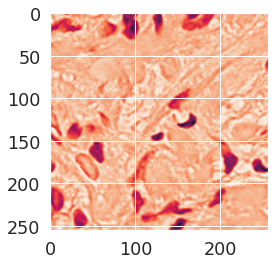

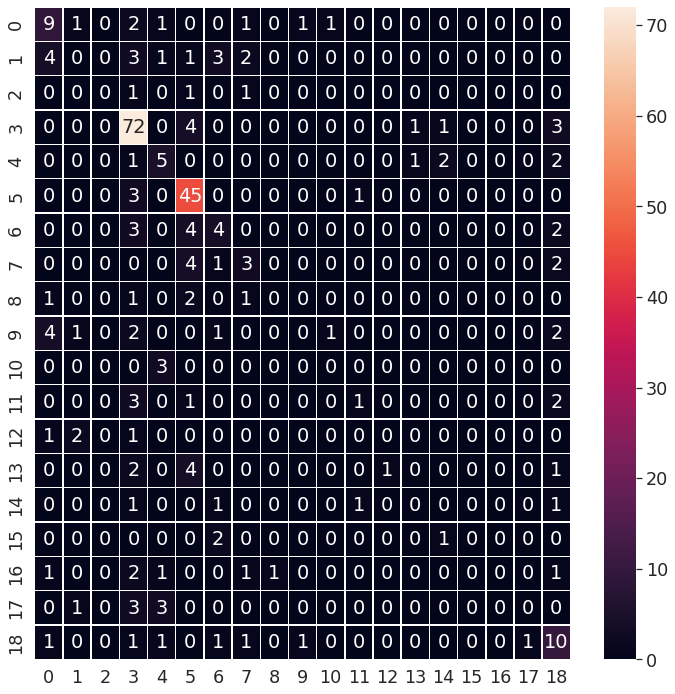

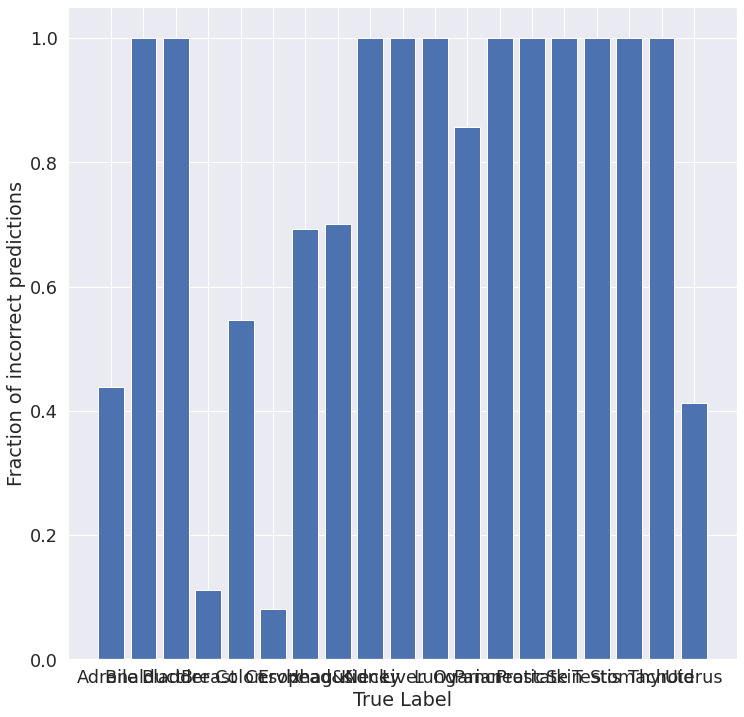

In [88]:
i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test2[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])


print("True Label: ", class_names[np.argmax(y_test2[i])])

from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test2, axis= 1), ideal_weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
fig, ax = plt.subplots(figsize=(12,12))
plt.bar(np.arange(19), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(19), class_names)

**Ensembling model 1 and model 2**

In [89]:
model12 = [model1, model2]


In [90]:
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)



In [91]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test2)
prediction2 = model2.predict(x_test2)


In [92]:
accuracy1 = accuracy_score(np.argmax(y_test2, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_test2, axis=1), np.argmax(prediction2, axis=1))
ensemble_accuracy = accuracy_score(np.argmax(y_test2, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.6190476190476191
Accuracy Score for model2 =  0.39194139194139194
Accuracy Score for average ensemble =  0.5531135531135531


In [93]:
#Weighted average ensemble
models = [model1, model2] 
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
weights = [.5,.5] #########this should be filled  

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test2, axis= 1), weighted_ensemble_prediction)

In [94]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6190476190476191
Accuracy Score for model2 =  0.39194139194139194
Accuracy Score for average ensemble =  0.5531135531135531
Accuracy Score for weighted average ensemble =  0.5641025641025641


In [95]:
### Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt

models = [model1, model2] 
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
ideal_weights = [.5,.5] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test2, axis= 1), ideal_weighted_ensemble_prediction)


Predicted Label:  Cervix
True Label:  Cervix


([<matplotlib.axis.XTick at 0x7fa691071410>,
 [Text(0, 0, 'Adrenal'),
  Text(0, 0, 'Bile duct'),
  Text(0, 0, 'Bladder'),
  Text(0, 0, 'Breast'),
  Text(0, 0, 'Colon'),
  Text(0, 0, 'Cervix'),
  Text(0, 0, 'Esophagus'),
  Text(0, 0, 'Head&Neck'),
  Text(0, 0, 'Kidney'),
  Text(0, 0, 'Liver'),
  Text(0, 0, 'Lung'),
  Text(0, 0, 'Ovarian'),
  Text(0, 0, 'Pancreatic'),
  Text(0, 0, 'Prostate'),
  Text(0, 0, 'Skin'),
  Text(0, 0, 'Testis'),
  Text(0, 0, 'Stomach'),
  Text(0, 0, 'Thyroid'),
  Text(0, 0, 'Uterus')])

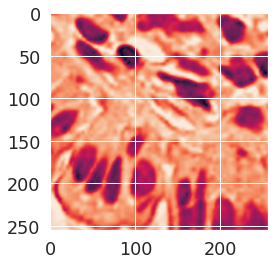

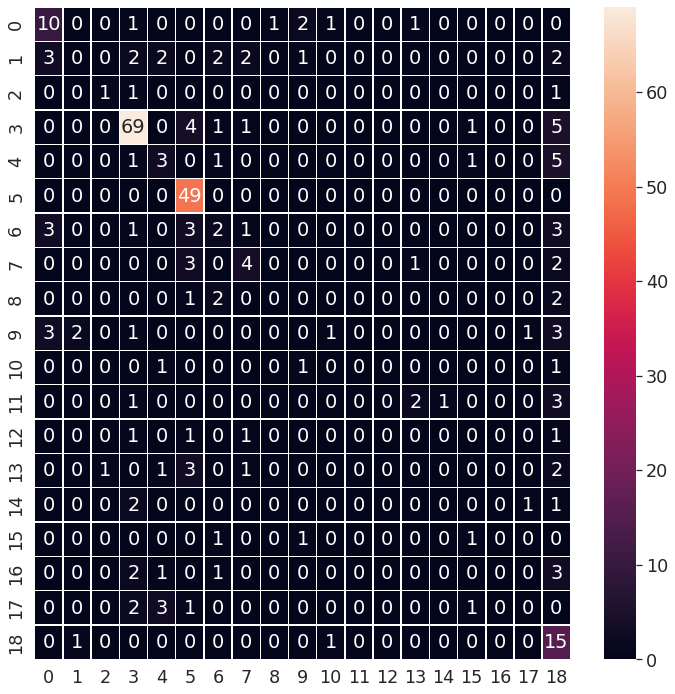

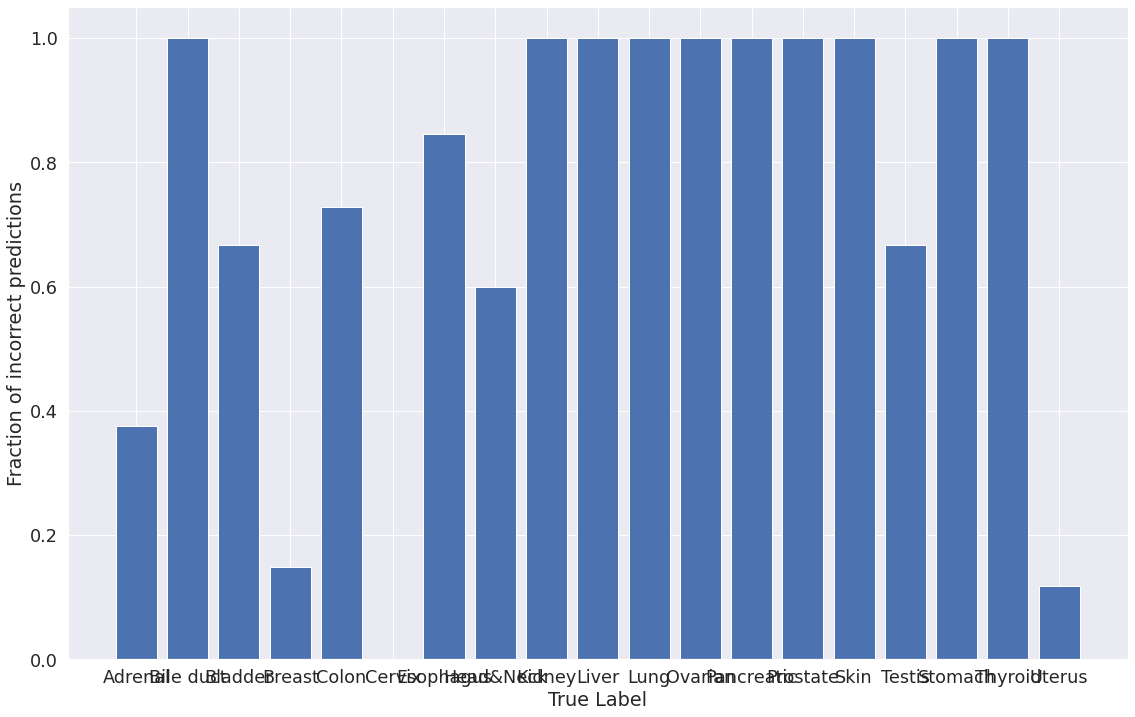

In [96]:
i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test2[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test2[i])])

from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test2, axis= 1), ideal_weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
fig, ax = plt.subplots(figsize=(19,12))
plt.bar(np.arange(19), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(19), class_names)



**Ensembling model 2 and model 3**

In [97]:
model23 = [model2, model3]

In [98]:
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [99]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test2)
prediction2 = model2.predict(x_test2)


In [100]:
accuracy1 = accuracy_score(np.argmax(y_test2, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_test2, axis=1), np.argmax(prediction2, axis=1))
ensemble_accuracy = accuracy_score(np.argmax(y_test2, axis=1), ensemble_prediction)

print('Accuracy Score for model2 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model2 =  0.6190476190476191
Accuracy Score for model3 =  0.39194139194139194
Accuracy Score for average ensemble =  0.5641025641025641


In [101]:
#Weighted average ensemble
models = [model2, model3] 
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
weights = [.5,.5] #########this should be filled  

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test2, axis= 1), weighted_ensemble_prediction)

In [102]:
print('Accuracy Score for model2 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy2)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model2 =  0.6190476190476191
Accuracy Score for model3 =  0.39194139194139194
Accuracy Score for average ensemble =  0.5641025641025641
Accuracy Score for weighted average ensemble =  0.4542124542124542


In [103]:
### Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt

models = [model1, model2] 
preds = [model.predict(x_test2) for model in models]
preds=np.array(preds)
ideal_weights = [.5,.5] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test2, axis= 1), ideal_weighted_ensemble_prediction)


Predicted Label:  Liver
True Label:  Lung


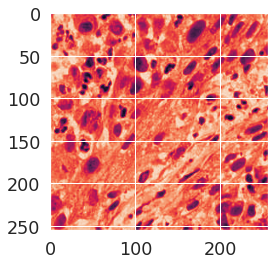

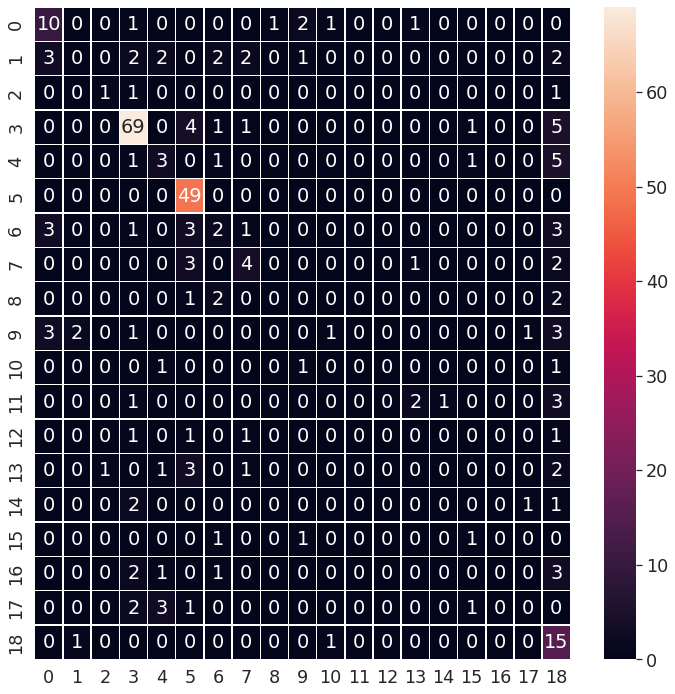

In [104]:
i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test2[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test2[i])])

from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test2, axis= 1), ideal_weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

